# Лабораторная работа 3. Свёрточные сети

#### Задание 1.
Построить свёрточную сеть LeNet-5 и обучить её распознаванию MNIST.

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time

In [27]:
import numpy as np
from collections import OrderedDict

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

In [30]:
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear)
               ToTensor()
           )

In [31]:
test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms)
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear)
               ToTensor()
           )

In [32]:
batch_size = 100
num_classes = 10
num_epochs = 10
learning_rate = 0.001

In [33]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [34]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## LeNet-5

In [10]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)),
            ('tanh1', nn.Tanh()),
            ('aver_pool1', nn.AvgPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)),
            ('tanh2', nn.Tanh()),
            ('aver_pool2', nn.AvgPool2d(kernel_size=2)),
            ('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)),
            ('tanh3', nn.Tanh()),
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(in_features=120, out_features=84)),
            ('tanh_linear', nn.Tanh()),
            ('output', nn.Linear(in_features=84, out_features=n_classes)),
        ]))


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [11]:
model = LeNet5(num_classes)
model.to(device)
model

LeNet5(
  (feature_extractor): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (tanh1): Tanh()
    (aver_pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (tanh2): Tanh()
    (aver_pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (tanh3): Tanh()
  )
  (classifier): Sequential(
    (linear): Linear(in_features=120, out_features=84, bias=True)
    (tanh_linear): Tanh()
    (output): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Обучение

In [35]:
def check_device(model):
    for parameter in model.named_parameters():
        print(f'{parameter[0]} on Cuda: {parameter[1].data.is_cuda}')

In [19]:
check_device(model)

feature_extractor.conv1.weight on Cuda: True
feature_extractor.conv1.bias on Cuda: True
feature_extractor.conv2.weight on Cuda: True
feature_extractor.conv2.bias on Cuda: True
feature_extractor.conv3.weight on Cuda: True
feature_extractor.conv3.bias on Cuda: True
classifier.linear.weight on Cuda: True
classifier.linear.bias on Cuda: True
classifier.output.weight on Cuda: True
classifier.output.bias on Cuda: True


In [36]:
def get_accuracy(m):
    from sklearn.metrics import accuracy_score
    pred_all = np.array([])
    labels_all = np.array([])
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs, _ = m(images)
            max_values, predicted = torch.max(outputs.data, 1)
            pred_all = np.append(pred_all, predicted.cpu().detach().numpy())
            labels_all = np.append(labels_all, labels.cpu().detach().numpy())
    acc = accuracy_score(pred_all, labels_all)
    return acc

In [37]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [38]:
loss_fn = nn.CrossEntropyLoss()

In [39]:
def learning(model, optimizer, num_epochs, log=False):
    losses = []
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)    
            # Forward pass
            outputs, _ = model(images)
            loss = loss_fn(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            if (i+1) % 100 == 0:
                losses.append(loss.item())
                if log: print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    return (get_accuracy(model), losses)

In [40]:
def draw(data):
    plt.plot(data)
    plt.ylabel('error')
    plt.xlabel('epoches')
    plt.show()

Epoch [1/10], Step [100/600], Loss: 0.4211
Epoch [1/10], Step [200/600], Loss: 0.2196
Epoch [1/10], Step [300/600], Loss: 0.2596
Epoch [1/10], Step [400/600], Loss: 0.1122
Epoch [1/10], Step [500/600], Loss: 0.1681
Epoch [1/10], Step [600/600], Loss: 0.1033
Epoch [2/10], Step [100/600], Loss: 0.0979
Epoch [2/10], Step [200/600], Loss: 0.1547
Epoch [2/10], Step [300/600], Loss: 0.0406
Epoch [2/10], Step [400/600], Loss: 0.1032
Epoch [2/10], Step [500/600], Loss: 0.1478
Epoch [2/10], Step [600/600], Loss: 0.0685
Epoch [3/10], Step [100/600], Loss: 0.0637
Epoch [3/10], Step [200/600], Loss: 0.0536
Epoch [3/10], Step [300/600], Loss: 0.0516
Epoch [3/10], Step [400/600], Loss: 0.0682
Epoch [3/10], Step [500/600], Loss: 0.0188
Epoch [3/10], Step [600/600], Loss: 0.0701
Epoch [4/10], Step [100/600], Loss: 0.0286
Epoch [4/10], Step [200/600], Loss: 0.1674
Epoch [4/10], Step [300/600], Loss: 0.0143
Epoch [4/10], Step [400/600], Loss: 0.0779
Epoch [4/10], Step [500/600], Loss: 0.1041
Epoch [4/10

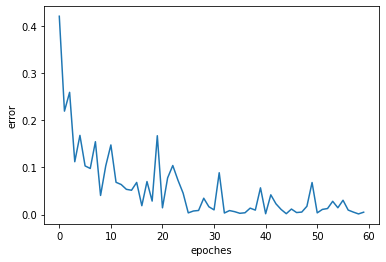

0.987

In [17]:
acc, data = learning(model, optimizer, num_epochs, log=True)
draw(data)
acc

#### Задание 2.
Поэкспериментировать с параметрами LeNet-5 и найти оптимальную архитектуру для MNIST.  

Параметры для подбора:
- количество свёрточных слоев (3 5 7)
- функция активации (Tanh, ReLU)
- способ субдискретизации (Average, Max)
- размер фильтров (3 5 7)
- количество фильтров (3 5 10)

In [182]:
list_conv_layers = [2, 3, 4]
list_activation_func = ['tanh', 'relu']
list_pooling = ['average', 'max']
list_filter_size = [
    [11, 11], # для 2x
    [5, 5, 5], # для 3x
    [5, 3, 3, 2], # для 4x
]
list_n_filters = [
    [1, 6, 16], # для 2x
    [1, 10, 60, 120], # для 3x
    [1, 4, 20, 40, 120], # для 4x
]

init_func = None
num_classes = 10
num_epochs = 10
learning_rate = 0.001

In [183]:
best_params = {
    'accuracy' : 0,
    'n_conv_layers' : None,
    'pooling' : None,
    'n_filters'  : None, 
    'activation_func' : None,
    'weight_init' : None,
    'data' : None,
}

In [184]:
class CNN(nn.Module):

    def __init__(self, n_classes, n_layers, activation_func, subsampling, filter_size, n_filters):
        super(CNN, self).__init__()
        
        net = OrderedDict()
        for i in range(len(filter_size)):
            net[f'conv{i}'] = nn.Conv2d(
                in_channels=n_filters[i], 
                out_channels=n_filters[i+1], 
                kernel_size=filter_size[i], 
                stride=1
            )
            net[f'actf{i}'] = self.get_activation_function(activation_func)
            if i != len(filter_size)-1:
                net[f'pooling{i}'] = self.get_pooling_type(subsampling)
        
        self.feature_extractor = nn.Sequential(net)

        self.classifier = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(in_features=n_filters[-1], out_features=84)),
            ('actf_linear', self.get_activation_function(activation_func)),
            ('output', nn.Linear(in_features=84, out_features=n_classes)),
        ]))
        
    def get_activation_function(self, af):
        if af == 'tanh':
            return nn.Tanh()
        elif af == 'relu':
            return nn.ReLU()
        return nn.ReLU()
    
    def get_pooling_type(self, t):
        return nn.AvgPool2d(kernel_size=2) if t == 'average' else nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [185]:
def init_weights(m):
    if type(m) == nn.Linear:
        if init_func == 'xavier':
            torch.nn.init.xavier_uniform_(m.weight, gain=1)
        elif init_func == 'kaiming':
            torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')    
        m.bias.data.fill_(0.01)

In [186]:
def get_activation_function(af):
    if af == 'tanh':
        return torch.tanh
    elif af == 'relu':
        return torch.relu
    return torch.relu

In [187]:
loss_fn = nn.CrossEntropyLoss()

In [188]:
from tqdm.notebook import tqdm

In [194]:
best_params['accuracy'] = 0
t = len(list_activation_func) * len(list_pooling) * len(list_filter_size)
pbar = tqdm(total=t)
#for n_conv_layers in list_conv_layers:
for act_func in list_activation_func:
    if act_func == 'tanh':
        init_func = 'xavier'
    elif act_func == 'relu':
        init_func = 'kaiming'
    for type_pooling in list_pooling:
        for filter_sizes, out_channels in zip(list_filter_size, list_n_filters):
            pbar.update(1)
            model = CNN(
                num_classes, 
                n_conv_layers, 
                act_func, 
                type_pooling, 
                filter_sizes, 
                out_channels
            )
            model.to(device)
            model.apply(init_weights)
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
            accuracy, data = learning(model, optimizer, num_epochs, log=False)
            #print(model)
            #print(accuracy)
            #draw(data)
            if accuracy > best_params['accuracy']:
                best_params = {
                    'accuracy' : accuracy,
                    'n_conv_layers' : len(filter_sizes),
                    'pooling' : type_pooling,
                    'n_filters'  : filter_sizes, 
                    'activation_func' : act_func,
                    'weight_init' : init_func,
                    'data' : data,
                }
                print('Update\n', best_params)
pbar.close()

Update
 {'accuracy': 0.982, 'n_conv_layers': 2, 'pooling': 'average', 'n_filters': [11, 11], 'activation_func': 'tanh', 'weight_init': 'xavier', 'data': [0.35549232363700867, 0.1650865375995636, 0.322992742061615, 0.356495201587677, 0.13780100643634796, 0.19126899540424347, 0.09112794697284698, 0.13177666068077087, 0.20147942006587982, 0.17811502516269684, 0.11910361051559448, 0.10495870560407639, 0.09335272759199142, 0.0874302014708519, 0.08506322652101517, 0.07924330979585648, 0.050622615963220596, 0.12259677797555923, 0.14925794303417206, 0.08187926560640335, 0.0412079319357872, 0.05572257936000824, 0.05366463586688042, 0.026629773899912834, 0.07427385449409485, 0.06337583810091019, 0.09116289019584656, 0.1348109394311905, 0.06304547935724258, 0.013038882985711098, 0.07149327546358109, 0.05067829042673111, 0.05002614110708237, 0.1323316991329193, 0.057347942143678665, 0.08246602863073349, 0.14033235609531403, 0.09803111851215363, 0.02846338041126728, 0.08773498237133026, 0.013477167

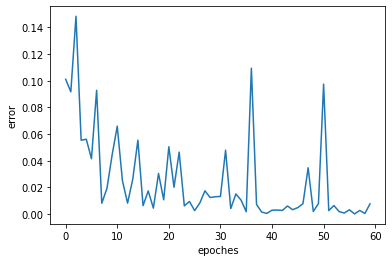

In [197]:
best_params
draw(best_params['data'])

#### Задание 3 (факультативное).
Построить свёрточную сеть по одной из рассмотренных архитектур (AlexNet, VGG, Inception, ResNet) и обучить её распознаванию MNIST.

#### Задание 4 (факультативное).
Прочитать параграф 5.3 в учебнике С. Николенко и др. (стр. 199–206) и воспроизвести рассмотренные там нейронные сети на TensorFlow и Keras.